
# Práctica de Laboratorio 3C — Análisis de Series Temporales (Filtro de Kalman y modelos VAR)

**Asignatura:** Análisis de Series Temporales  
**Curso:** 2025–2026  

**Autores:**  
Marius Marinescu  
Vanesa Gómez Martínez
Cristian David Chushig Muzo  
Eva Milara Hernando  

**Afiliación:**  
Universidad Rey Juan Carlos  
Departamento de Teoría de la Señal y Comunicaciones y Sistemas Telemáticos y Computación  

## Objetivo general

El objetivo de esta práctica es implementar y aprender a utilizar el **filtro de Kalman** en diferentes aplicaciones de predicción y estimación en series temporales.

Además, el último bloque introduce el uso del filtro de Kalman en modelos **VAR (Vector Autoregressive)** para el análisis y predicción de series multivariantes.

En particular, se trabajan:

- Implementación del algoritmo del filtro de Kalman.
- Predicción de procesos ARMA usando representación en espacio de estados.
- Estimación recursiva de parámetros de modelos AR mediante Kalman.
- Predicción en datos reales mediante modelos en espacio de estados.
- Aplicación del filtro de Kalman a modelos VAR multivariantes.

El cuaderno combina desarrollo matemático, simulación, visualización e interpretación estadística, y está diseñado como material docente en acceso abierto.

---

## Estructura

1. Implementación del filtro de Kalman  
2. Predicción de procesos ARMA mediante Kalman  
3. Estimación en tiempo real de parámetros AR con Kalman  
4. Predicción en datos reales (temperatura — Svedala)  
5. Predicción multivariante VAR mediante Kalman  

---



---
# <center> Practica III | Parte C </center>
---


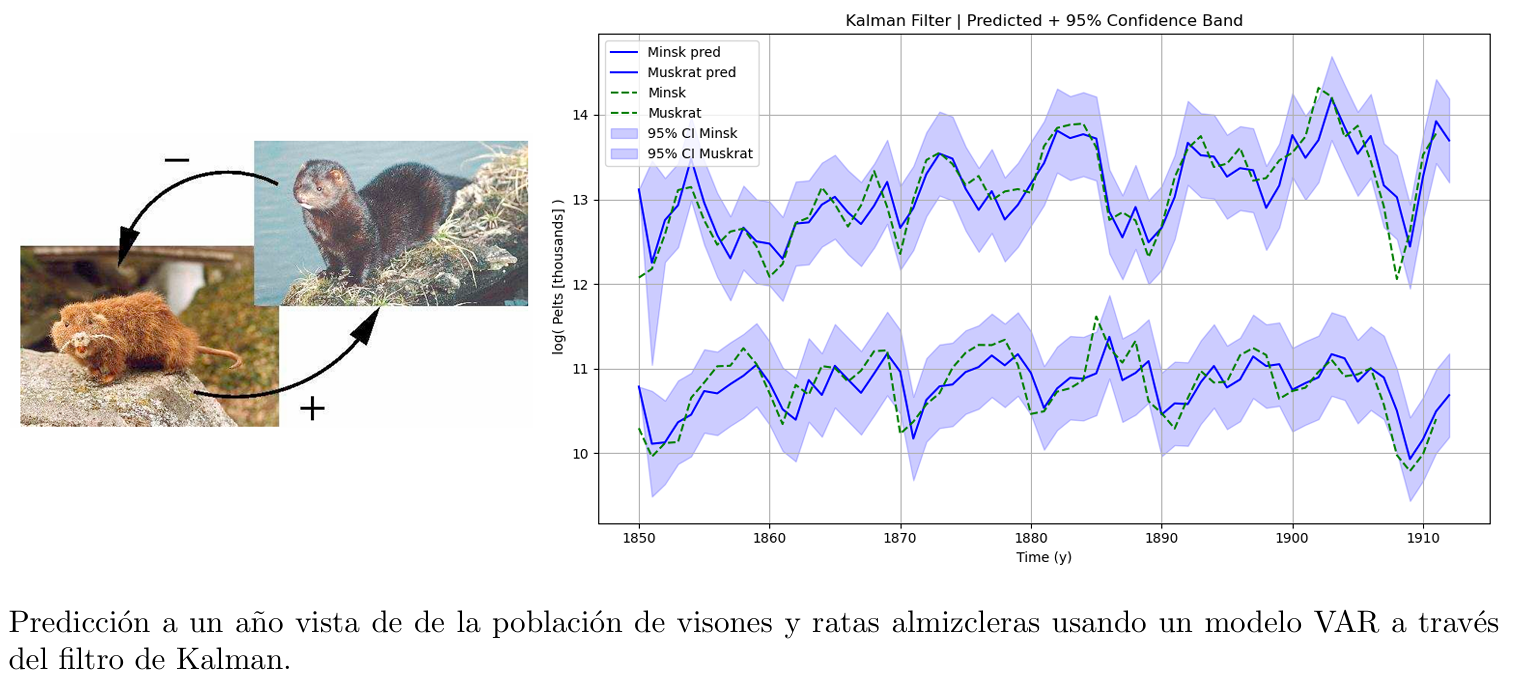

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [22]:
### Split a cell: Ctrl + M + -
import sys
from pathlib import Path

# IMPORTANT: Replace this with the ACTUAL path to your 'functions' folder in Google Drive.
notebook_dir = Path('/content/drive/MyDrive/Colab Notebooks/AST/Practica III KF/')
functions_path = notebook_dir / 'functions'
#functions_path = Path('/content/drive/MyDrive/Colab Notebooks/AST/Practica III KF/functions')

# Add the subfolder to sys.path
sys.path.insert(0, str(functions_path))

# Now you can import from the module inside the subfolder
# Assuming 'KF_fun.py' exists in your 'functions' subfolder
from KF_fun import kalman_predict, kalman_update
###


In [7]:
import numpy as np
import matplotlib.pyplot as plt

## 1 Implementar el filtro de Kalman

Se implementa en KF_fun.py

In [6]:
# AR2 Parameter tracking

# IMPORTANT: Adjust this path if 'magic_sample_average.txt' is not in the same directory as the notebook
# Based on your functions_path, it's likely located here:
# notebook_dir = Path('/content/drive/MyDrive/Colab Notebooks/AST/Practica III KF/')
y = np.loadtxt(notebook_dir / 'magic_sample_average.txt')
n_steps = len(y)

M = np.array([[1.0]])
H = np.array([[1.0]])

w_std = np.sqrt(0.0)
Q = np.array([[w_std**2]])

v_std = np.sqrt(1)
R = np.array([[v_std**2]], dtype=float)


measurements  = np.zeros(n_steps)
estimates     = np.zeros((n_steps, 2))
pos_std       = np.zeros(n_steps)   # <-- for confidence band

# first step
x = np.array([[0]])         # initial estimate
P = np.diag([1**2])    # initial covariance

# --- Main loop ---------------------------------------------
for t in range(1,n_steps):

    x, P = kalman_update(x, P, y[t], H, R)

    estimates[t] = x
    pos_std[t] = np.sqrt(P[0, 0])      # std of position (sqrt of diagonal)

    x, P = kalman_predict(x, P, M, Q)

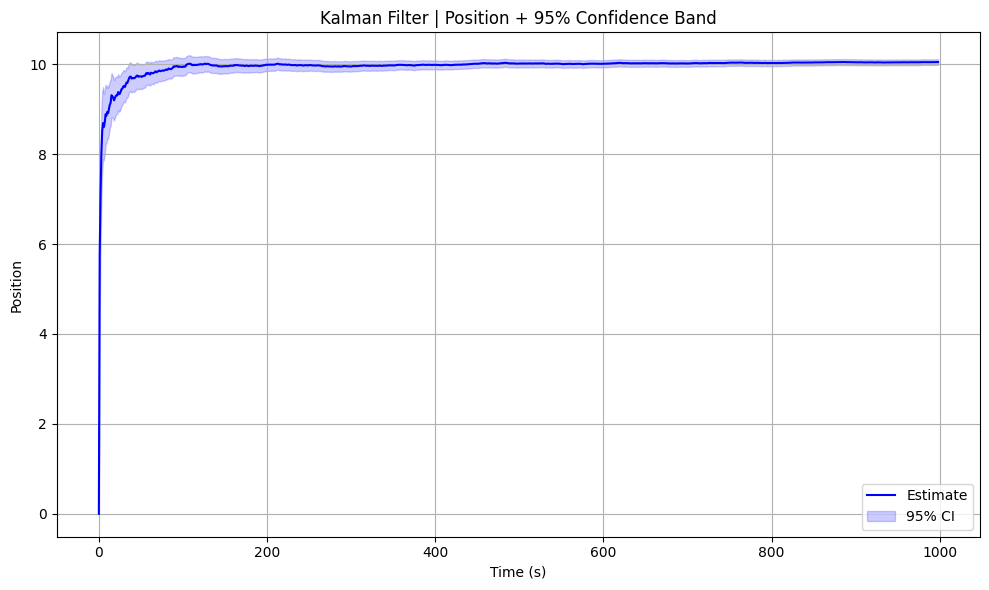

In [8]:
# --- Plot with 95% confidence interval --------------------
times = np.arange(n_steps)
ci = 1.96 * pos_std                     # 95% for Gaussian

plt.figure(figsize=(10, 6))
plt.plot(times, estimates[:, 0],     "b-",  label="Estimate")

plt.fill_between(times,
                 estimates[:, 0] - ci,
                 estimates[:, 0] + ci,
                 color="b", alpha=0.2, label="95% CI")
plt.legend()
plt.title("Kalman Filter | Position + 95% Confidence Band")
plt.xlabel("Time (s)")
plt.ylabel("Position")
plt.grid(True)
plt.tight_layout()
plt.show()

P1

**¿Cuál es el valor desconocido $x_t$ para $t>>0$ ? Compáralo con $\bar{y}$. ¿Qué confianza tienes en dicha estimación?**

El valor es 10. Es muy similar a $\bar{y}$, el filtro parece tender a $\bar{y}$. Una confianza grande, la desviación estandar es $\pm 0.0316$.

In [12]:
pos_std[-1]

np.float64(0.03163859985841664)

## Predecir un ARMA(2,2) con el filtro de Kalman

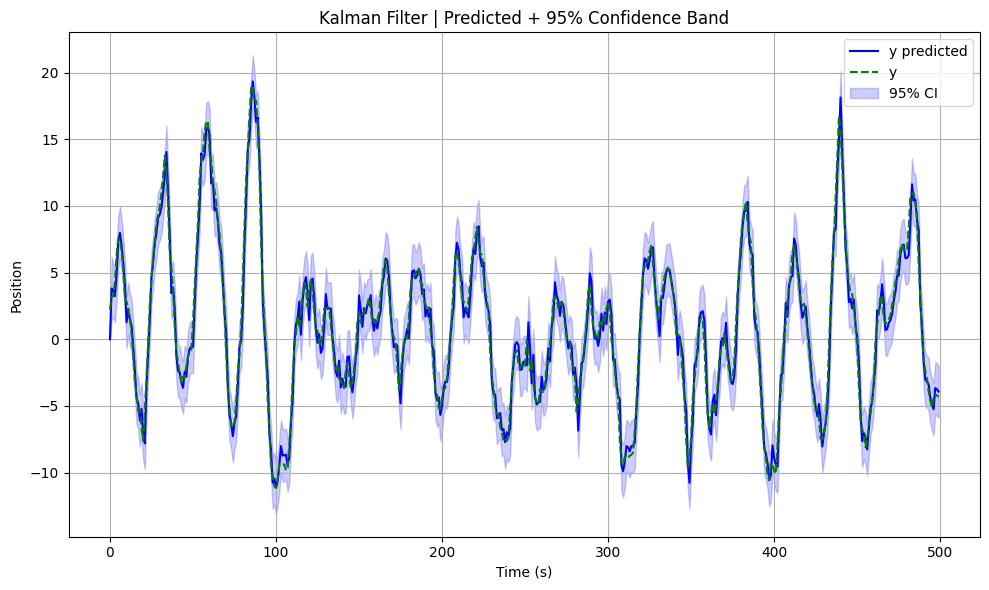

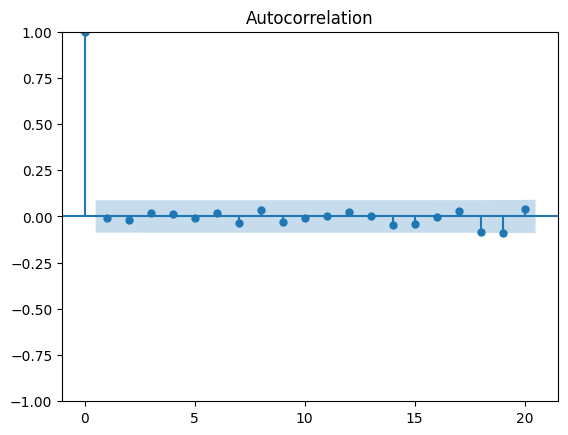

MAE: 


np.float64(0.7461487567923009)

In [20]:
y = np.loadtxt(notebook_dir / 'ARMA2_2_data.txt')
n_steps = len(y)
k = 1 # <-- CHOOSE prediction step


pos_std       = np.zeros(n_steps)   # <-- for confidence band
ypred  = np.zeros(n_steps)


a = np.array([-1.79, 0.84 ])
c = np.array([-0.18, -0.11])

Q = np.array([[1, 0, 0],
          [0, 0, 0],
          [0, 0, 0]])
R = np.array([[.0]])
M = np.array([np.hstack([-a, 0]),
          [1, 0, 0],
          [0, 1, 0]])
H = np.hstack([1, c]).reshape(1, -1)

# first step
x = np.array([0, 0, 0])         # initial estimate
P = np.diag([1, 1, 1])    # initial covariance


# --- Main loop ---------------------------------------------
for t in range(0,n_steps-k):

    # Update
    x, P = kalman_update(x, P, y[t], H, R)

    # Predicion
    x, P = kalman_predict(x, P, M, Q)

    # k-step predicion
    xf = x
    for i in range(2,k):
        xf, P = kalman_predict(xf, P, M, Q)

    ypred[t+k] = np.squeeze(H @ xf)
    pos_std[t+k] = np.sqrt(np.squeeze(H @ P @ H.T + R))  # std of position (sqrt of diagonal)

# --- Plot with 95% confidence interval --------------------
times = np.arange(n_steps)
ci = 1.96 * pos_std                     # 95% for Gaussian

plt.figure(figsize=(10, 6))
plt.plot(times, ypred,     "b-",  label="y predicted")

plt.plot(times, y[0:n_steps],     "g--",  label="y")
plt.fill_between(times,
                 ypred - ci,
                 ypred + ci,
                 color="b", alpha=0.2, label="95% CI")
plt.legend()
plt.title("Kalman Filter | Predicted + 95% Confidence Band")
plt.xlabel("Time (s)")
plt.ylabel("Position")
plt.grid(True)
plt.tight_layout()
plt.show()



# ACF
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(y[1:]-ypred[1:], lags=20)
plt.show()

# MAE
print('MAE: ')
np.mean(np.abs(y-ypred))

P2

**¿Se pueden considerar los errores de predicción ruido blanco?**

Sí. La predicción es óptima, hemos visto en clase que los errores siguen un proceso MA(k-1), donde k indica el horizonte temporal de predicion. Para k = 1 es ruido blanco. Esto se confirma con la ACF (no hay correlación, como en el caso del ruido blanco).

P3

**¿Es la ACF como te lo esperas?**

Sí, representa la ACF de un MA(3), es decir los tres primeros lags son significativos.

## Estimar en tiempo real los coeficientes de un AR(2) con el filtro de Kalman

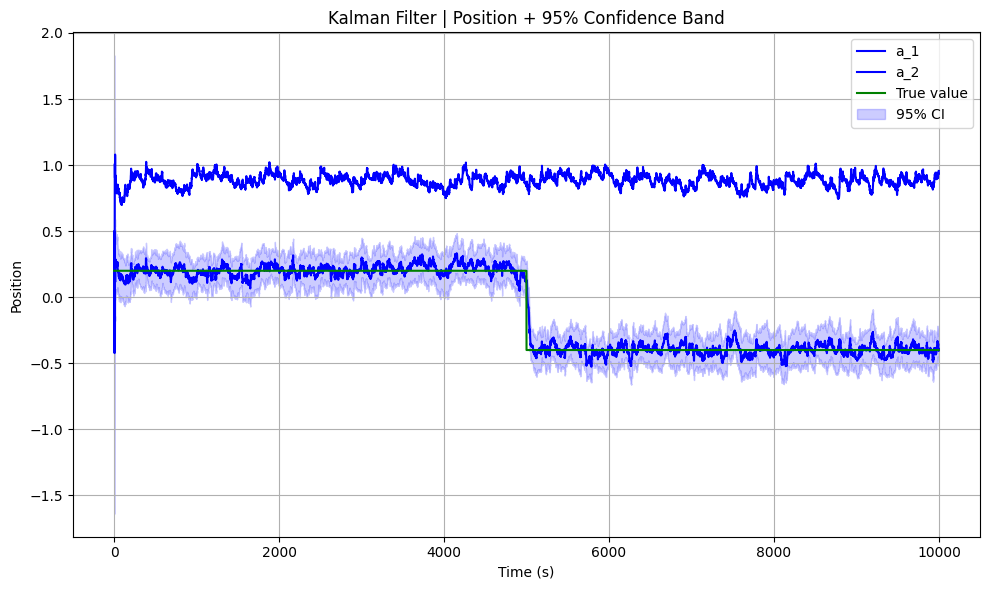

In [27]:
# AR2 Parameter tracking
y = np.loadtxt(notebook_dir / 'AR2_data.txt')
n_steps = len(y)


M = np.array([[1.0, 0],
              [0.0, 1.0]])
H = np.array([[y[0], 0]], dtype=float)

w_std = np.sqrt(0.0001)
Q = w_std**2 * np.array([[1, 0],
                               [0, 1]])

v_std = np.sqrt(1)
R = np.array([v_std**2], dtype=float)


measurements  = np.zeros(n_steps)
estimates     = np.zeros((n_steps, 2))
pos_std       = np.zeros(n_steps)   # <-- for confidence band

# first step
x = np.array([0.5, 0.5])         # initial estimate
P = np.diag([1**2, 1**2])    # initial covariance

# --- Main loop ---------------------------------------------
for t in range(1,n_steps):

    x, P = kalman_update(x, P, y[t], H, R)

    H[0,1] = H[0,0]
    H[0,0] = -y[t]
    #H = np.array([y[t-1], y[t-2]]).reshape(1, 2)

    estimates[t] = x
    pos_std[t] = np.sqrt(P[0, 0])      # std of position (sqrt of diagonal)

    x, P = kalman_predict(x, P, M, Q)

# --- Plot with 95% confidence interval --------------------
times = np.arange(n_steps)
ci = 1.96 * pos_std                     # 95% for Gaussian

plt.figure(figsize=(10, 6))
plt.plot(times, estimates[:, 0],     "b-",  label="a_1")
plt.plot(times, estimates[:, 1],     "b-",  label="a_2")

# AST secret code
a1 = np.array([0.2, -.4 ])
a2 = np.array([0.9, 0.9 ])
rep = 5000
a1=np.repeat(a1,rep)
a2=np.repeat(a2,rep)

# Plot
plt.plot(times, a1[1:],     "g-",  label="True value")
plt.fill_between(times,
                 estimates[:, 0] - ci,
                 estimates[:, 0] + ci,
                 color="b", alpha=0.2, label="95% CI")
plt.legend()
plt.title("Kalman Filter | Position + 95% Confidence Band")
plt.xlabel("Time (s)")
plt.ylabel("Position")
plt.grid(True)
plt.tight_layout()
plt.show()

P4

**¿Son las matrices de transición constantes? ¿Es posible aplicar el filtro de Kalman?**

No, no lo son.  Aunque no es necesario que lo sean, el filtro de Kalman es extremadamente versátil y lo permite (siempre y cuando se les de las matrices apropiadas).

P5

**Según los datos, que valor/es de R  pueden ser apropiados?**

Idealmente la varianza de $e_t$, aunque como no la conocemos podemos darle la varianza muestral de $y_t$ como una cota superior y hacer que el algoritmo confie menos en las estimaciones iniciales.

P6

**Representa los valores estimados en una linea temporal. ¿Cual parece ser el valor de los parámetros? ¿Son estos constantes?**

Parece que $a_1$ empieza en $\approx$ 0.2 pero cambia a mitad de camino a -0.4. Por el otro lado $a_2$ parece ser constantemente  $\approx$ 0.9. Por lo que no, no son constantes. Esto muestra otra útil capacidad del filtro de Kalman y es que es capaz de estimar un proceso ARMA online, donde los coeficientes cambian con el tiempo.


## Predecir la temperatura en Svedala, Suecia

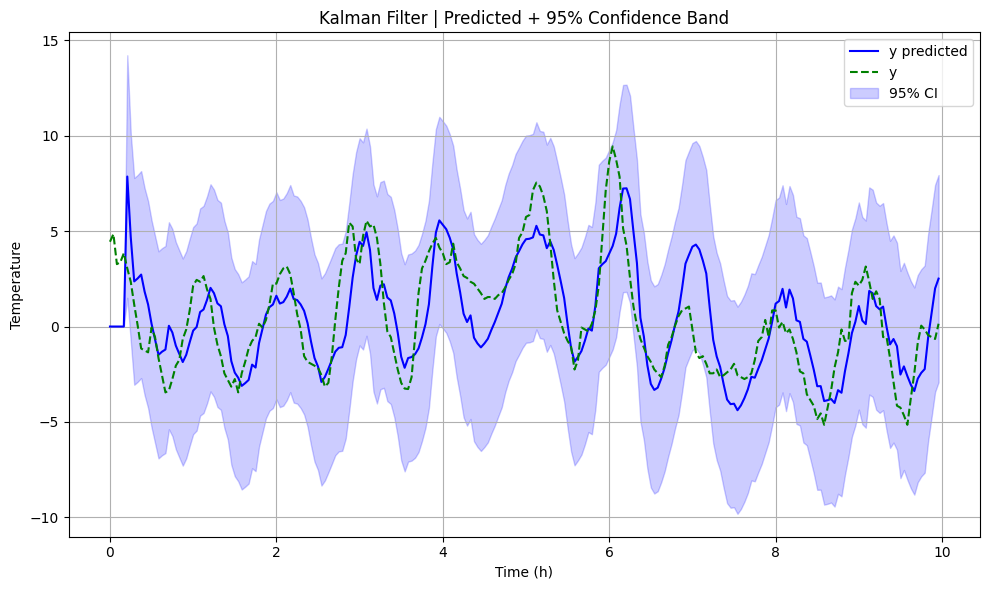

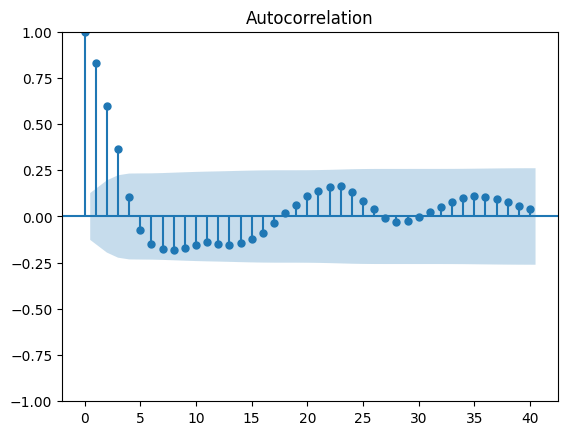

RMSE: 

2.0779805836797083


In [26]:
y = np.loadtxt(notebook_dir / 'svedala.txt')

y = y[(40-1)*24: (50-1)*24] # Only data from 40 to 50 day as required
n_steps = 240 # len(y) # 1361 425 240
k = 5 # prediction step
model = 2

measurements  = np.zeros(n_steps)
pos_std       = np.zeros(n_steps)   # <-- for confidence band
ypred  = np.zeros(n_steps)
yhat2  = np.zeros(n_steps)

sig2 =   5.8139 # np.var(y) o Segun pem(modelo=2) V(e)= 5.8139


if model == 1:

    a = np.array([-1.79, 0.84 ])
    c = np.array([-0.18, -0.11])

    Q = np.array([[1, 0, 0],
              [0, 0, 0],
              [0, 0, 0]])
    R = np.array([[.0]])
    M = np.array([np.hstack([-a, 0]),
              [1, 0, 0],
              [0, 1, 0]])
    H = np.hstack([1, c]).reshape(1, -1)

    # first step
    x = np.array([0, 0, 0])         # initial estimate
    P = np.diag([1, 1, 1])    # initial covariance

elif model == 2:
    a = np.array([ - 3.751, 5.3368, - 3.4079, 0.8224 ]); p = len(a)
    c = np.array([- 2.3056, 1.4174, 0.0773, -0.0633,  - 0.1176]); q = len(c)

    d = max(p , q + 1)
    Q = np.zeros((d,d)); Q[0,0]=1

    R = np.array([[1e-5]])

    M = np.eye(d-1)
    if d>p:

        M = np.vstack([ np.hstack([-a, np.zeros((d-p-1))]), M])
        M = np.hstack([M, np.zeros((d,1))]); M[0, -1] = 0

        H = np.hstack([1, c]).reshape(1, -1)
    else:
        M = np.hstack([M, np.zeros((d-1,1))]);
        M = np.vstack([ -a, M])

        H = np.hstack([1, c, np.zeros((1, d-q-1))]).reshape(1, -1)

    # first step
    x = np.zeros(d)        # initial estimate
    P = np.eye(d)    # initial covariance

# --- Main loop ---------------------------------------------
for t in range(0,n_steps-k):

    x, P = kalman_update(x, P, y[t], H, R)

    # predicion
    x, P = kalman_predict(x, P, M, Q)

    # k-step predicion
    xf = x
    for i in range(2,k):
        xf, P = kalman_predict(xf, P, M, Q)

    ypred[t+k] = np.squeeze(H @ xf)
    pos_std[t+k] = np.sqrt(np.squeeze(H @ P @ H.T + R))      # std of position (sqrt of diagonal)



# --- Plot with 95% confidence interval --------------------
times = np.arange(n_steps)/24
ci = 1.96 * pos_std                     # 95% for Gaussian

plt.figure(figsize=(10, 6))
plt.plot(times, ypred,     "b-",  label="y predicted")

plt.plot(times, y[0:n_steps],     "g--",  label="y")
plt.fill_between(times,
                 ypred - ci,
                 ypred + ci,
                 color="b", alpha=0.2, label="95% CI")
plt.legend()
plt.title("Kalman Filter | Predicted + 95% Confidence Band")
plt.xlabel("Time (h)")
plt.ylabel("Temperature")
plt.grid(True)
plt.tight_layout()
plt.show()



# ACF
plot_acf(y[1:]-ypred[1:], lags=40)
plt.show()
print('RMSE: \n')
rmse = np.sqrt(np.mean((y - ypred)**2))
print(rmse)

P7

**¿Qué modelo es mejor?**

La ACF del modelo 2 es un MA(4) mientras que la del modelo 1 MA(35). Además, el RMSE del modelo 2 es  $\approx$ 2 mientras que en modelo 1 es  $\approx$ 2.5. Por lo que se puede considerar que el modelo 2 es mejor.


## Prediciendo la población de visones y ratas almizcleras con un modelo VAR

P8

**Escribe el modelo anterior como un modelo de espacios de estados.**

```

"""
VAR(p) can be expressed as:
    
    x = M x_t-1 + Ge_t
    y = H x_t
    
    with M = [A1 A2 ... Ap-1 Ap;
              I 0 ... 0 0 ;
              0 I ... 0 0;
              0 0 ... I 0]
    
         H = [I 0 0 ... 0]
         G = H'
         
"""
```



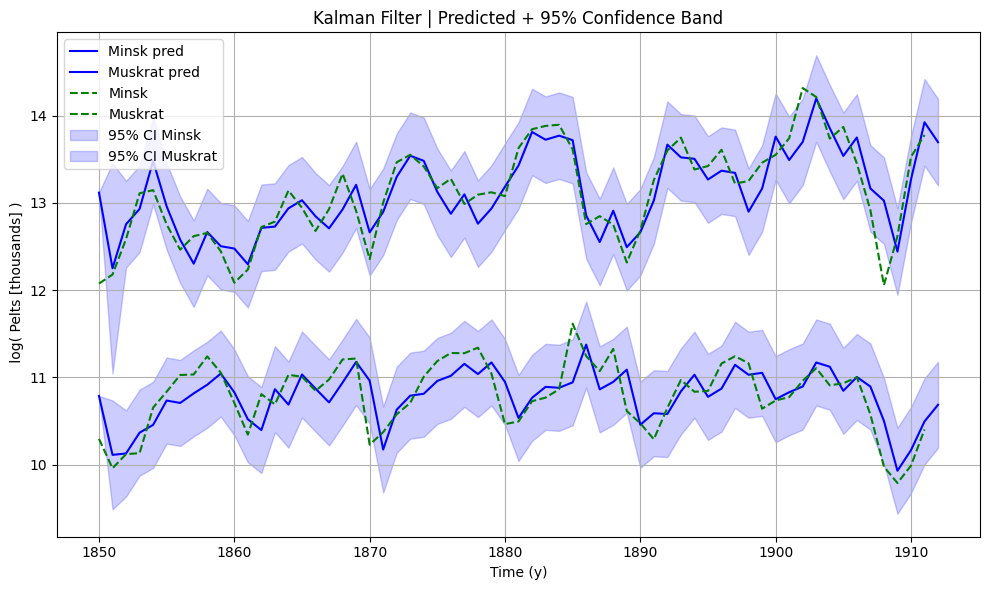

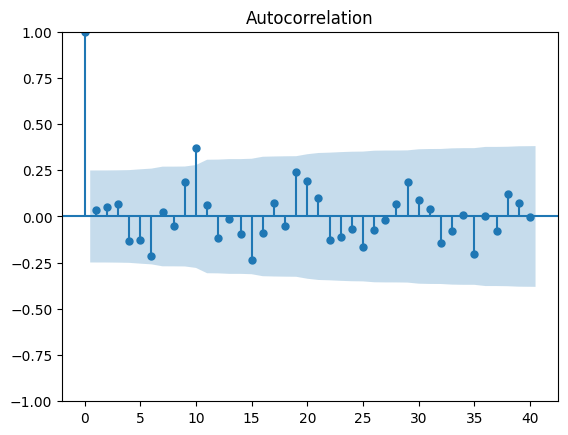

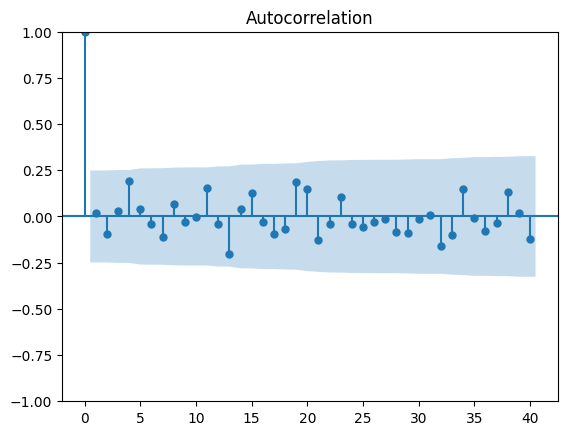

Para 1912 predice una venta MEDIANA de: 
 [ 43771.44 886953.18]
MEDIAN CI.: 
 [ 26730. 540135.] [  71677. 1456461.]
Con un coef. de variacion de +-%: 
 [2.33 1.93]
Variance reduction: 1- RMSE/STD[y]
[0.27 0.49]


In [34]:

data = np.loadtxt(notebook_dir / 'mink_muskrat.txt', delimiter=',', skiprows=1)

times = data[:, 0] # years
y = data[:, 1:3]

y = np.log(y); mu = np.mean(y,  axis = 0) # 0 - by columns 1 - by rows
y = y - mu
n_steps = len(y) # 62


k = 1 # prediction step
p = 2 # past lags
n = 2 # number of variables of the state vector

measurements  = np.zeros(n_steps)
pos_std       = np.zeros((n_steps+1, 2))   # <-- for confidence band
ypred  = np.zeros((n_steps+1, n))

yhat  = np.zeros((n_steps, n))

# thEst =

#    -0.7036   -0.3159    0.0466    0.1894
#     0.7553   -1.1878   -0.4505    0.3344

# VAR coefficient matrices A1 and A2 (example values)
A1 = -np.array([[-0.7036,   -0.3159],
               [0.7553,   -1.1878]])

A2 = -np.array([[0.0466,    0.1894],
               [-0.4505,    0.3344]])


# Process noise covariance

np_state = n * p

# Transition matrix M
M = np.zeros((np_state, np_state))
M[0:n, 0:n] = A1
M[0:n, n:2*n] = A2
M[n:2*n, 0:n] = np.eye(n)      # shifts y_{t-1} down

# Observation matrix H
H = np.zeros((n, np_state))
H[:, 0:n] = np.eye(n)


R = np.eye(n) * 1e-5
Q = np.zeros((np_state, np_state))
Q[0:n, 0:n] = np.array([[0.0633, 0.0203],
                        [0.0203, 0.0640]])

# first step
x = np.zeros(np_state)        # initial estimate
P = np.eye(np_state)    # initial covariance

# --- Main loop ---------------------------------------------
for t in range(0,n_steps-k+1):

    x, P = kalman_update(x, P, y[t], H, R)
    yhat[t, :] = x[0:2]

    # predicion
    x, P = kalman_predict(x, P, M, Q)

    # k-step predicion
    xf = x
    for i in range(2,k):
        xf, P = kalman_predict(xf, P, M, Q)

    ypred[t+k, :] = H @ xf
    pos_std[t+k, :] = np.sqrt(np.diag(H @ P @ H.T + R))      # std of position (sqrt of diagonal)


ypred = ypred + mu
y = y + mu
yhat = yhat + mu

# Representation in original scale / 1e3 (comment/uncomment)
# ypred = np.exp(ypred + mu)/1e3
# y = np.exp(y + mu)/1e3
# yhat = np.exp(yhat + mu)/1e3

# --- Plot with 95% confidence interval --------------------
ci = 1.96 * pos_std                     # 95% for Gaussian

plt.figure(figsize=(10, 6))
plt.plot(np.hstack([times, 1912]), ypred,     "b-",  label = ["Minsk pred", "Muskrat pred"])
#plt.plot(times, yhat,     "b-",  label = ["Minsk pred", "Muskrat pred"])
#plt.legend(["Minsk pred", "Muskrat pred"])

plt.plot(times, y,     "g--",  label=["Minsk", "Muskrat"])
plt.fill_between(np.hstack([times, 1912]),
                 ypred[:,0] - ci[:,0],
                 ypred[:,0] + ci[:,0],
                 color="b", alpha=0.2, label="95% CI Minsk")

plt.fill_between(np.hstack([times, 1912]),
                 ypred[:,1] - ci[:,1],
                 ypred[:,1] + ci[:,1],
                 color="b", alpha=0.2, label="95% CI Muskrat")

plt.legend()
plt.title("Kalman Filter | Predicted + 95% Confidence Band")
plt.xlabel("Time (y)")
plt.ylabel(" log( Pelts [thousands] )")
plt.grid(True)
plt.tight_layout()
plt.show()

ypred2 = ypred[:-1,:]
# ACF 1
plot_acf(y[:,0]-ypred2[:,0], lags=40)
plt.show()

# ACF 2
plot_acf(y[:,1]-ypred2[:,1], lags=40)
plt.show()


# Metricas

# No se puede hace simplemente exp(std) ya que al hacer log la std se sesga por
# la transformacion. Sin embargo la mediana no es afectada!

# COMO LOG ES UNA TRANSFORMACION MONOTONA SE RESPETA LOS QUANTILES.
# EN PARTICULAR LA MEDIANA Y LOS CUANTILES QUE DAN EL INTERVALO
# DE CONFIANZA DEL 95%. En distr.normal MEDIANA = MEDIA
# al aplicar exp(MEDIA o MEDIANA) = MEDIANA NUEVA.

# Resultados y métricas

print("Para 1912 predice una venta MEDIANA de: \n",  np.round(np.exp(ypred[-1,:]), 2) )

# El CI sale no simetrico porque exp(x-a) no es simetrico respecto de a. CI DE LA MEDIANA:
print("MEDIAN CI.: \n", np.round(np.exp(  ypred[-1,:] - ci[-1,:] )), np.round(np.exp( ypred[-1,:] + ci[-1,:]  )) )

# Coef. de var. CV:
    # Permite comparar la dispersión de datos que no tienen la misma escala o unidades.
    # Medida estadística de dispersión relativa

# Un CV por debajo del 7% indica alta precisión, mientras que un CV mayor al 20%
# sugiere una estimación poco precisa.
print("Con un coef. de variacion de +-%: \n",  np.round( pos_std[-1,:] / mu *100, 2 ) )

rmse = np.sqrt(np.mean( (np.exp(y) - np.exp(ypred2))**2,  axis = 0));
# RMSE relative to the original std
print("Variance reduction: 1- RMSE/STD[y]")
print( np.round(1 - rmse / np.std(np.exp(y), axis = 0), 2 ))




P9

**¿Que ventas se espera para el año 1912? Proporción un intervalo de confianza para esos valores. ¿Es el intervalo simétrico?**

Se espera una venta de unos 43771 886953 miles de pieles de visones y ratas almizcleras, respectivamente.

Los intervalos de confianza son:

Visones: [ 26730. 540135.]

Ratas almizcleras: [  71677. 1456461.]

El intervalo no es simetrico respecto a la esperanza, debido a la transformacion logaritmica aplicada al modelar.